## 이미지 노이즈 제거


In [27]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

### 데이터 로드

In [28]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

### 데이터 전처리

In [29]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### 임의의 노이즈 추가

In [30]:
noise_factor = 0.2

x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

### 노이즈가 추가된 이미지 확인

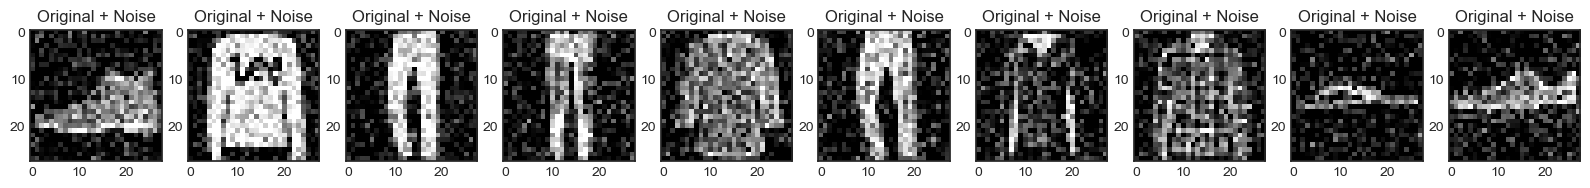

In [31]:
n = 10
plt.figure(figsize=(20,2))
for i in range(n):
    ax=plt.subplot(1, n, i+1)
    plt.title("Original + Noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### 모델 정의

In [32]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        
        self.encoder = Sequential([Input(shape=(28,28,1)),
                                   Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
                                   Conv2D(8, (3,3), activation='relu', padding='same', strides=2),
                                   ])
        self.decoder = Sequential([Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
                                   Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
                                   Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')
                                   ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 모델 생성 및 컴파일

In [35]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

### 모델 학습

In [36]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0159 - val_loss: 0.0093
Epoch 2/10
1875/1875 [==============================] - 23s 13ms/step - loss: 0.0085 - val_loss: 0.0081
Epoch 3/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 4/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 6/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 8/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 9/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 10/10
1875/1875 [==============================] - 23s 12m

### 인코더 요약

In [37]:
autoencoder.encoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


### 디코더 요약

In [38]:
autoencoder.decoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


### 노이즈가 있는 이미지와 없는 이미지 시각화

In [39]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs= autoencoder.decoder(encoded_imgs).numpy()

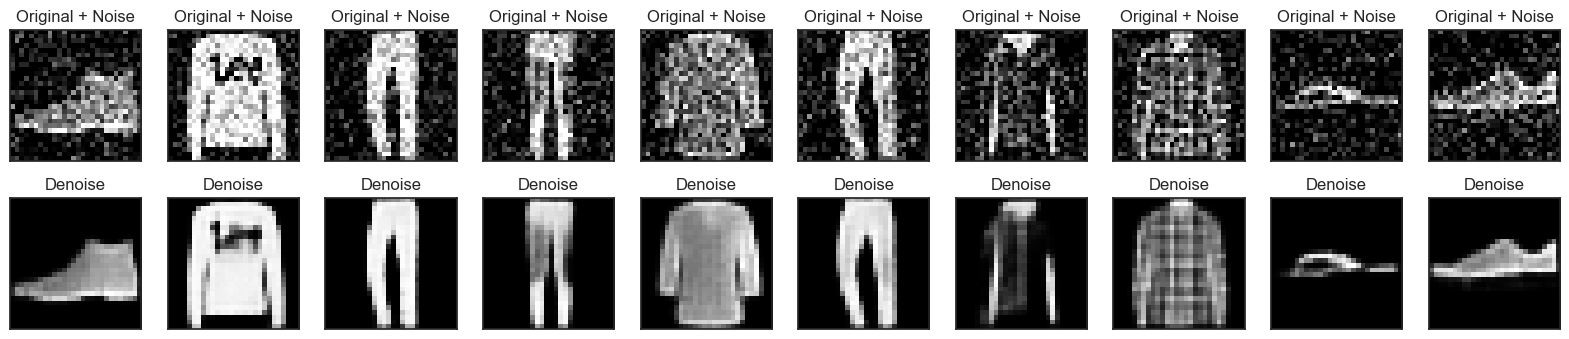

In [41]:
n=10
plt.figure(figsize=(20,4))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.title('Original + Noise')
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    bx = plt.subplot(2, n, i+1+n)
    plt.title('Denoise')
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
    
plt.show()

## Reference

https://www.youtube.com/watch?v=QUSJ5dTLd8E&list=PL7ZVZgsnLwEElur9LpRW9w3NYGVgA3n6t&index=8